In [1]:
%matplotlib inline

import geopandas
import regionmask

import pandas as pd
import xarray as xr

ModuleNotFoundError: No module named 'geopandas'

In [2]:
# create GeoDataFrame with all HUC2 elements
# huc 2 to 4, should WBDHU2.shp
dfs = []
hucs = list(range(1, 19))
for i in hucs:
    huc2_file = f'/glade/u/home/jhamman/projects/storylines/data/gis/WBD_{i:02d}_Shape/Shape/WBDHU2.shp'
    gdf = geopandas.GeoDataFrame.from_file(huc2_file)
    dfs.append(gdf)
gdf = pd.concat(dfs)
gdf.index = hucs
gdf.head()

,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC2,NAME,SHAPE_LENG,SHAPE_AREA,geometry
1,{87290825-BAC9-4D07-8A32-E35A873C0BD1},None,None,None,None,20170816000649,2730131,49135499.18,198844.49,"CN,CT,MA,ME,NH,NY,RI,VT",01,New England Region,48.2984344819978,22.4854347168858,(POLYGON ((-73.02573148771478 41.2130396099875...
2,{4AEF9DDF-A9C6-400E-8FD8-180FD5C29F69},None,None,None,None,20170816000624,2730132,68320130.43,276482,"CT,DC,DE,MA,MD,NJ,NY,PA,RI,VA,VT,WV",02,Mid Atlantic Region,52.4177510650764,29.2456409326581,(POLYGON ((-73.0255572637567 41.21326637769545...
3,{9C77B5BA-946A-4537-BADD-990373DEFFBB},None,None,None,None,20170801122959,2730133,182774403.26,739662.42,"AL,FL,GA,LA,MS,NC,SC,TN,VA",03,South Atlantic-Gulf Region,69.8844227515357,71.0064380485419,"POLYGON ((-79.4782105318659 37.50766332823895,..."
4,{EBD12DC7-3886-4A92-BF58-E3147628761B},None,None,None,None,20170807182410,2730134,152474968.05,617044.85,"CN,IL,IN,ME,MI,MN,NH,NY,OH,PA,VT,WI",04,Great Lakes Region,166.233809505139,70.0158950771809,POLYGON ((-88.00263874050927 49.02244801140739...
5,{5C6AE09C-4CFC-4EBA-9344-A91AF35E73E8},None,None,None,None,20170627161550,2730135,104270021.21,421966.18,"IL,IN,KY,MD,NC,NY,OH,PA,TN,VA,WV",05,Ohio Region,61.3943869537108,43.813407644068,"POLYGON ((-79.03733301900854 42.4486251580696,..."


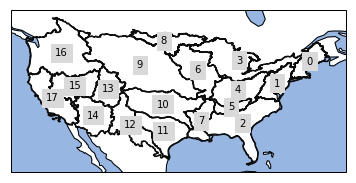

In [3]:
# Create a Regions object for masking
huc_mask = regionmask.Regions_cls('USmask', range(len(gdf)), gdf.STATES.values, list(map(str, hucs)), gdf.geometry.values)
huc_mask.plot()

/glade/u/home/jhamman/miniconda3/envs/loca/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: load_dataset` will be removed in a future version of xarray. The current behavior of this function can be achived by using `tutorial.open_dataset(...).load()`.
  


<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.49 296.19 295.69
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

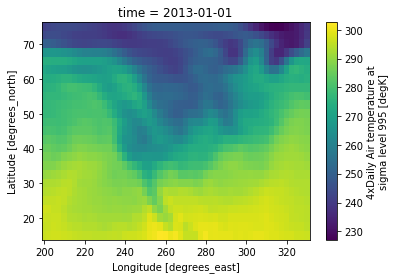

In [4]:
# load an xarray dataset
airtemps = xr.tutorial.load_dataset('air_temperature')
display(airtemps)
airtemps['air'].isel(time=0).plot()

<xarray.DataArray 'region' (lat: 25, lon: 53)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0

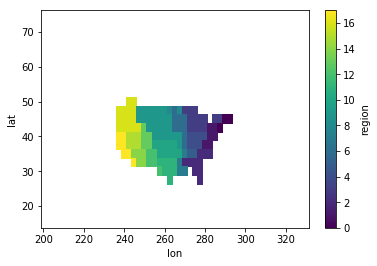

In [5]:
# Create a mask object
mask = huc_mask.mask(airtemps, wrap_lon=True)
display(mask)
mask.plot()

In [6]:
# Group data by huck. 
data_by_huc = airtemps.groupby(mask).mean('stacked_lat_lon')
display(data_by_huc)

<xarray.Dataset>
Dimensions:  (region: 18, time: 2920)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * region   (region) float64 0.0 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0 16.0 17.0
Data variables:
    air      (region, time) float32 267.32666 269.53333 ... 273.33286 273.5043

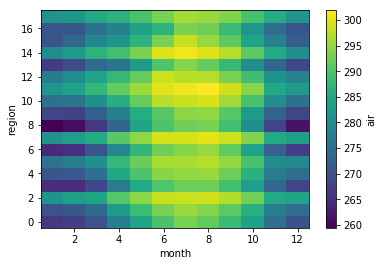

In [7]:
# calculate the annual cycle and plot
data_by_huc.air.groupby('time.month').mean('time').plot()